# Predictive Energy Grid Optimizer: Time-Series Forecasting & Market Regime Analysis

**Author:** Mykhailo Isupov

---

## Introduction
Electricity demand must be balanced with generation in real time, making short-term load forecasting a standard and important problem in power systems.

This notebook implements an end-to-end machine learning pipeline to predict short-term electrical grid load using historical time-series data. The primary objective is to compare a well-tuned classical machine learning model against a deep learning sequence model. By doing so, we aim to evaluate whether increased model complexity translates to meaningful performance improvements on structured, tabular temporal data.

## Methodology Overview
The pipeline is structured into five distinct phases:

1. **Feature Engineering & Preprocessing:** Handling missing data, encoding cyclical time coordinates, and generating autoregressive lag features to capture short-term momentum.
2. **Unsupervised Regime Detection:** Using Principal Component Analysis (PCA) and K-Means clustering to identify hidden market states or "regimes."
3. **Supervised Classical Baseline:** Establishing a performance baseline using a hyperparameter-tuned Decision Tree Regressor, validated via strict chronological splitting to prevent data leakage.
4. **Deep Learning Sequence Model:** Reshaping the tabular data into 3D tensors to train a Long Short-Term Memory (LSTM) neural network.
5. **Evaluation & Visualization:** Comparing Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) across models, and visualizing the final load predictions.

---

## Phase 1: Data Acquisition & Preprocessing ##

The first step is to acquire the raw data and isolate the variables we need. We use the Kaggle API to download the energy dataset, which contains 4 years of hourly records.

In [1]:
import kaggle as kg
import pandas as pd
import numpy as np

In [2]:
# Download the dataset directly via Kaggle API
dataset_path = "nicholasjhana/energy-consumption-generation-prices-and-weather"
kg.api.dataset_download_files(dataset=dataset_path, path='.', unzip=True)
print("Download complete.")

csv_filename = 'energy_dataset.csv'

Dataset URL: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
Download complete.


In [3]:
# Load the data
df = pd.read_csv(csv_filename)
print("\nData successfully loaded.")
print(f"Dataset Shape: {df.shape}")


Data successfully loaded.
Dataset Shape: (35064, 29)


In [4]:
# Inspect the initial structure
print(df.head())

                        time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.

### Feature Isolation & Chronological Sorting
The raw dataset contains numerous external features, including weather data. To avoid the "forecast error double penalty" — where models trained on *actual* historical weather fail in production when fed imperfect weather *forecasts* — we will strictly isolate our analysis to endogenous grid variables: time, load, and price.

In [5]:
# Parse the time column to proper datetime objects
df['time'] = pd.to_datetime(df['time'], utc=True)
# Isolate the target variables
cols_to_keep = ['time', 'total load actual', 'price actual']
df = df[cols_to_keep]

In [6]:
# Rename columns so they are easier to type
df.rename(columns={
    'total load actual': 'load',
    'price actual': 'price'
}, inplace=True)

# Sort chronologically just in case
df = df.sort_values('time').reset_index(drop=True)

### Handling Missing Data
Time-series models require continuous data. Dropping missing rows would create time gaps and disrupt lag features. Instead, we use linear interpolation to bridge missing sensor readings based on nearby data points.

In [7]:
# Check for missing values
print(f"Missing values before:\n{df.isna().sum()}\n")

# Use linear interpolation to estimate missing points based on surrounding data
df['load'] = df['load'].interpolate(method='linear')
df['price'] = df['price'].interpolate(method='linear')

print(f"Missing values after:\n{df.isna().sum()}")

Missing values before:
time      0
load     36
price     0
dtype: int64

Missing values after:
time     0
load     0
price    0
dtype: int64


### Cyclical Time Encoding
If we encode time as regular numbers, it is treated as linear. For example, hour 23 and hour 0 look far apart numerically (difference of 23), even though they are only one hour apart in reality.

Distance-based algorithms like K-Means or PCA would interpret this as a large jump.

To fix this, we encode hour and month using sine and cosine transformations, mapping them onto a circle. This preserves the natural cyclical pattern of time.

In [8]:
# Extract raw hour and month
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month

# Cyclical encoding for Hour (Period = 24)
df['hour_sin'] = np.sin(df['hour'] * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df['hour'] * (2. * np.pi / 24))

# Cyclical encoding for Month (Period = 12)
df['month_sin'] = np.sin(df['month'] * (2. * np.pi / 12))
df['month_cos'] = np.cos(df['month'] * (2. * np.pi / 12))

# Drop the raw hour and month columns, we don't need them anymore
df.drop(['hour', 'month'], axis=1, inplace=True)

### Autoregressive Lag Features
To help the models capture short-term trends in the grid, we create autoregressive lag features.

This means we shift the dataset and include the load and price from 1 hour ago and 24 hours ago as input features for the current time step.

These lag features allow the model to use recent past information when making predictions.

In [9]:
# Create lag features for Load
df['load_lag_1'] = df['load'].shift(1)
df['load_lag_24'] = df['load'].shift(24)

# Create lag features for Price
df['price_lag_1'] = df['price'].shift(1)
df['price_lag_24'] = df['price'].shift(24)

# Because we shifted by 24 hours, the first 24 rows now have NaNs.
# We must drop these initial rows.
df = df.dropna().reset_index(drop=True)

# Set the datetime as the index
df.set_index('time', inplace=True)

print(df.head())

                              load  price  hour_sin  hour_cos  month_sin  \
time                                                                       
2015-01-01 23:00:00+00:00  27070.0  64.02 -0.258819  0.965926        0.5   
2015-01-02 00:00:00+00:00  24935.0  58.46  0.000000  1.000000        0.5   
2015-01-02 01:00:00+00:00  23214.0  54.70  0.258819  0.965926        0.5   
2015-01-02 02:00:00+00:00  22540.0  54.91  0.500000  0.866025        0.5   
2015-01-02 03:00:00+00:00  22096.0  53.07  0.707107  0.707107        0.5   

                           month_cos  load_lag_1  load_lag_24  price_lag_1  \
time                                                                         
2015-01-01 23:00:00+00:00   0.866025     26798.0      25385.0        64.13   
2015-01-02 00:00:00+00:00   0.866025     27070.0      24382.0        64.02   
2015-01-02 01:00:00+00:00   0.866025     24935.0      22734.0        58.46   
2015-01-02 02:00:00+00:00   0.866025     23214.0      21286.0        54.70   

## Phase 2: Unsupervised Market Regime Detection ##

Energy grids can operate under different patterns, such as stable baseload periods, high-demand evening peaks, or unusual weather-driven spikes. Before applying supervised forecasting models, we use unsupervised learning to identify these underlying regimes.

To better understand how dimensionality reduction works, we implement feature standardization and Principal Component Analysis (PCA) manually using NumPy. This includes explicitly computing the covariance matrix and performing eigenvalue decomposition, rather than relying only on library functions.

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [11]:
def standardize(X):
    """Standardizes features to have zero mean and unit variance."""
    # Ensure X is a numpy array
    X = np.array(X)
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

def pca(X, n_components):
    """Projects X onto the top 'n_components' eigenvectors of its covariance matrix."""
    # Center the data
    X_centered = X - np.mean(X, axis=0)

    # Calculate the Covariance Matrix
    # rowvar=False treats columns as discrete variables
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Perform Eigen Decomposition
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    # to capture the axes of maximum variance
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Slice the top k eigenvectors
    eigenvectors_subset = sorted_eigenvectors[:, :n_components]

    # Project the original data into the reduced dimensional space
    X_reduced = np.dot(X_centered, eigenvectors_subset)

    # Return the real part
    return np.real(X_reduced)

### Dimensionality Reduction
PCA maximizes variance, making it highly sensitive to the scale of input features. We first standardize the raw matrix to ensure features like `load` (measured in thousands) do not mathematically overpower the cyclical time coordinates (bounded between -1 and 1). We then project the dataset down to 3 orthogonal principal components, reducing multicollinearity and providing a cleaner geometric space for clustering.

In [12]:
# Convert our Pandas DataFrame strictly to a NumPy matrix
X_raw = df.values

# Standardize the matrix
X_scaled = standardize(X_raw)

print(f"Mean of scaled data: {np.mean(X_scaled):.2f}")
print(f"Std Dev of scaled data: {np.std(X_scaled):.2f}")

# Apply our PCA to reduce from 8 dimensions down to 3
X_pca = pca(X_scaled, n_components=3)

print(f"Shape of projected matrix: {X_pca.shape}")

Mean of scaled data: 0.00
Std Dev of scaled data: 1.00
Shape of projected matrix: (35040, 3)


### Determining the Optimal Number of Regimes
K-Means clustering requires a predefined number of clusters ($k$). To determine the optimal $k$, we use the Elbow Method, tracking the Within-Cluster Sum of Squares (Inertia) across multiple values of $k$ to identify the point of diminishing returns.

*Note: Because this analysis operates on a static historical dataset, a visual heuristic is sufficient. In a live production pipeline, an automated metric (such as the Calinski-Harabasz Index or Kneedle algorithm) would be preferred to dynamically recalculate the optimal number of regimes as grid volatility shifts.*

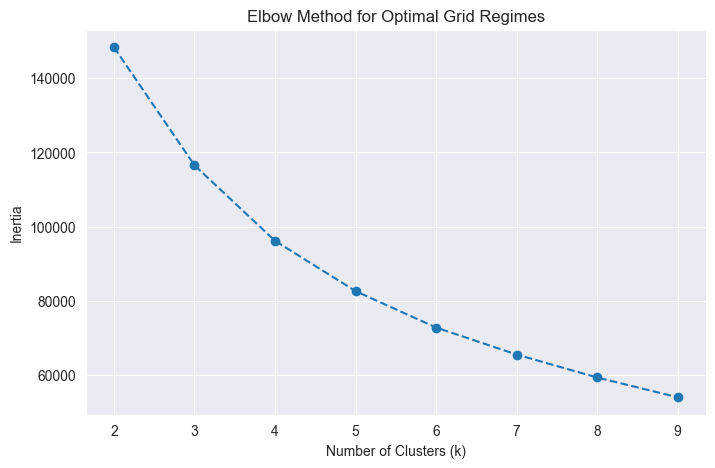

In [13]:
inertia = []
K_range = range(2, 10)

# Test k values from 2 to 9 on our PCA output
for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(X_pca)
    inertia.append(kmeans_test.inertia_)



# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Grid Regimes')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

### Extracting and Mapping Regimes
From the Elbow curve, we choose 4 clusters as the optimal number. We run K-Means on the 3D PCA-transformed data and assign each point a cluster label.

We then add these labels as a new `cluster_regime` feature in the original dataset. This gives our supervised model explicit information about the current state of the grid.

In [14]:
# Initialize the final K-Means model
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit the model to our 3D vector space and extract the labels
cluster_labels = kmeans_final.fit_predict(X_pca)


# Append the new 'cluster_regime' feature back to our original Pandas DataFrame
df['cluster_regime'] = cluster_labels

print("\nData points per regime:")
print(df['cluster_regime'].value_counts())


Data points per regime:
cluster_regime
2    10760
0     9646
1     9177
3     5457
Name: count, dtype: int64


## Phase 3: Supervised Learning — Classical Baseline ##

Before moving to more complex deep learning models, it is good practice to first build a strong baseline using a classical algorithm. This allows us to compare performance and see whether a neural network actually provides a meaningful improvement.

For this baseline, we use a Decision Tree Regressor because it is interpretable and can capture non-linear patterns in structured data.

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [16]:
# 1. Define Features (X) and Target (y)
# Drop 'price' to prevent future data leakage, and 'load' because it is our target
y = df['load'].values
X = df.drop(columns=['load', 'price']).values

### Chronological Validation (Preventing Lookahead Bias)

In typical regression problems, data is often shuffled randomly before splitting into training and test sets. However, in time-series forecasting, this is not valid because it would allow the model to train on future data. For example, the model could indirectly use Tuesday’s information to predict Monday’s load. This creates lookahead bias and leads to overly optimistic results.

To properly evaluate the model, we use a strict **chronological split**:
1. **Training Set (First 80%)** – Earlier historical data
2. **Test Set (Final 20%)** – Later, unseen data

In [17]:
# 2. Primary Train/Test Split (80% Train, 20% Test)
# This strictly chronologically separates the past from the "future"
split_index = int(len(X) * 0.8)
X_train_full, X_test = X[:split_index], X[split_index:]
y_train_full, y_test = y[:split_index], y[split_index:]

# 3. Secondary Validation Split for Optimization
# We take the 80% training data and split it AGAIN (75% train, 25% validate)
# to test our tree depths without touching the final test set.
val_split_index = int(len(X_train_full) * 0.75)
X_t, X_v = X_train_full[:val_split_index], X_train_full[val_split_index:]
y_t, y_v = y_train_full[:val_split_index], y_train_full[val_split_index:]

### Hyperparameter Optimization (Bias-Variance Tradeoff)
The performance of a Decision Tree depends strongly on its maximum depth.
* **Too shallow (underfitting)**: The model is too simple and cannot capture important patterns in the data.
* **Too deep (overfitting)**: The model learns noise from the training data and does not perform well on new, unseen data.

To find the best `max_depth`, we train multiple trees with different depths using the training subset (`X_t`) and evaluate their performance on a separate validation subset (`X_v`).

In [18]:
print("Running hyperparameter optimization for max_depth...")

depths_to_test = range(2, 26)
val_errors = []

# 4. The Optimization Loop
for d in depths_to_test:
    # Initialize a tree for the current depth
    test_tree = DecisionTreeRegressor(max_depth=d, random_state=42)
    test_tree.fit(X_t, y_t)

    # Predict on the validation set and record the Mean Absolute Error
    val_pred = test_tree.predict(X_v)
    val_errors.append(mean_absolute_error(y_v, val_pred))

# Find the depth that produced the absolute lowest validation error
optimal_depth = depths_to_test[np.argmin(val_errors)]
print(f"Mathematically optimal max_depth found: {optimal_depth}")

Running hyperparameter optimization for max_depth...
Mathematically optimal max_depth found: 11


### Final Baseline Evaluation
With the optimal hyperparameter identified, we retrain the Decision Tree on the *full* historical training set (`X_train_full`) to maximize its learning. We then evaluate its final performance on the unseen Test Set (`X_test`) using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

In [19]:
# 5. Train the Final Baseline Model
# Now that we know the best depth, we train a new tree using that exact depth
# on the ENTIRE historical training set (X_train_full)
final_dt_model = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
final_dt_model.fit(X_train_full, y_train_full)

# 6. Final Evaluation on the Unseen Test Set
y_pred_final = final_dt_model.predict(X_test)
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f"\n--- Final Baseline Performance ---")
print(f"Mean Absolute Error (MAE): {mae_final:.2f} MW")
print(f"Root Mean Squared Error (RMSE): {rmse_final:.2f} MW")


--- Final Baseline Performance ---
Mean Absolute Error (MAE): 490.32 MW
Root Mean Squared Error (RMSE): 754.97 MW


## Phase 4: Deep Learning — LSTM Sequence Model ##

Decision Trees treat each hour as an independent observation. However, in reality, electricity load is sequential — the load at 3:00 PM depends on what happened at 2:00 PM.

To model this time dependency, we implement a **Long Short-Term Memory (LSTM)** neural network, which is designed to learn patterns across sequences.

### Data Scaling & Tensor Reshaping

Neural networks are trained using gradient descent, which is sensitive to the scale of input features. If one feature has values around 30,000 (e.g., `load`) and another is between -1 and 1 (e.g., `hour_sin`), training can become unstable.

To avoid this, we apply `StandardScaler` to normalize all features to a similar scale.

In addition, LSTMs require data in a 3D format:

`(Samples, Time Steps, Features)`

instead of a standard 2D table.

We use a sliding window approach to convert the tabular dataset into sequential batches suitable for LSTM training.

In [20]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
# 1. Initialize scalers for BOTH X and y
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# 2. Scale the data
# This is the crucial step we missed: scaling the input features!
X_scaled_for_lstm = x_scaler.fit_transform(X)
y_scaled_for_lstm = y_scaler.fit_transform(y.reshape(-1, 1))

# 3. The Sliding Window Function
def create_sequences(X_data, y_data, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - time_steps):
        X_seq.append(X_data[i:(i + time_steps)])
        y_seq.append(y_data[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# 4. Create the 3D tensors using the SCALED X matrix
TIME_STEPS = 24
X_3d, y_3d = create_sequences(X_scaled_for_lstm, y_scaled_for_lstm, TIME_STEPS)

# 5. Chronological Split
split_idx = int(len(X_3d) * 0.8)

X_train_lstm = X_3d[:split_idx]
X_test_lstm = X_3d[split_idx:]
y_train_lstm = y_3d[:split_idx]
y_test_lstm = y_3d[split_idx:]

print("Data successfully scaled and chunked into 3D tensors.")

Data successfully scaled and chunked into 3D tensors.


### LSTM Architecture

We design a simple sequential model for short-term forecasting:
1. **LSTM Layer (64 units)**: Learns patterns across time and captures sequential dependencies in the data.
2. **Dropout (0.2)**: Randomly drops 20% of neurons during training to reduce overfitting.
3. **Dense Layer (1 unit)**: Produces a single output value — the predicted load.

In [22]:
# Initialize the Sequential model
model = Sequential()

# Add the LSTM layer
# input_shape strictly expects (Time_Steps, Features)
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))

# Add Dropout for regularization
model.add(Dropout(0.2))

# Add the final output layer
model.add(Dense(units=1))

# Compile the engine
# Adam optimizer adaptively changes the learning rate as it gets closer to the minimum loss
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

C:\Users\mykha\PycharmProjects\Energy_Prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training
We train the model for 15 epochs. Crucially, we set `shuffle=False`. In standard image classification, you shuffle data to ensure randomness. In time-series, shuffling breaks the continuity of the grid state, destroying the very patterns the LSTM is trying to learn.

In [23]:
print("Initiating LSTM Training Sequence...")

# Train the model for 15 passes (epochs) over the data
# A batch_size of 32 means it updates its mathematical weights after every 32 hours of data
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=15,
    batch_size=32,
    validation_split=0.1, # 10% used strictly for validation during training
    shuffle=False # NEVER shuffle time-series data during training!
)

Initiating LSTM Training Sequence...
Epoch 1/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1962 - val_loss: 0.1087
Epoch 2/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0924 - val_loss: 0.0792
Epoch 3/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0747 - val_loss: 0.0632
Epoch 4/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0647 - val_loss: 0.0536
Epoch 5/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0580 - val_loss: 0.0506
Epoch 6/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0539 - val_loss: 0.0480
Epoch 7/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0510 - val_loss: 0.0414
Epoch 8/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0473 - val_loss: 0.0400
Epoch 9/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0449 - val_loss: 0.0384
Epoch 10/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0429 - val_loss: 0.0372
Epoch 11/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0410 - val_loss: 0.0371
Epoch 12/15

### Inverse Transformation & Evaluation
The model outputs predictions in the scaled unit space (roughly -3 to 3). To evaluate performance against our baseline, we must mathematically invert this scaling to return to real-world Megawatts (MW).

In [24]:
# 1. Generate predictions on the test set
y_pred_scaled = model.predict(X_test_lstm)

# 2. Inverse transform the predictions and the actual test targets back to Megawatts
y_pred_mw = y_scaler.inverse_transform(y_pred_scaled)
y_test_mw = y_scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# 3. Calculate final metrics
lstm_mae = mean_absolute_error(y_test_mw, y_pred_mw)
lstm_rmse = np.sqrt(mean_squared_error(y_test_mw, y_pred_mw))

print(f"\n--- Deep Learning (LSTM) Performance ---")
print(f"Mean Absolute Error (MAE): {lstm_mae:.2f} MW")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse:.2f} MW")

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

--- Deep Learning (LSTM) Performance ---
Mean Absolute Error (MAE): 539.57 MW
Root Mean Squared Error (RMSE): 783.12 MW


## Phase 5: Visualization & Analysis

To validate our findings, we move beyond summary metrics (MAE/RMSE) and inspect the actual behavior of our models.

### Data Alignment
A direct comparison requires careful index alignment. The Decision Tree predicts on the full test set, while the LSTM prediction window is shortened by the look-back period (24 hours). We calculate the precise index offset to ensure that the Decision Tree predictions, LSTM predictions, and Actual Load values correspond to the exact same timestamps.

### Visualization Strategy
We employ three visualization techniques to assess performance:
1.  **Time-Series Overlay:** A 2-week zoom to inspect how well each model captures daily seasonality and peak demand.
2.  **Error Distribution (Residuals):** A histogram of prediction errors. A taller, narrower peak at 0 indicates a model with higher stability and precision.
3.  **Performance Scorecard:** A side-by-side bar chart of the final MAE and RMSE metrics.

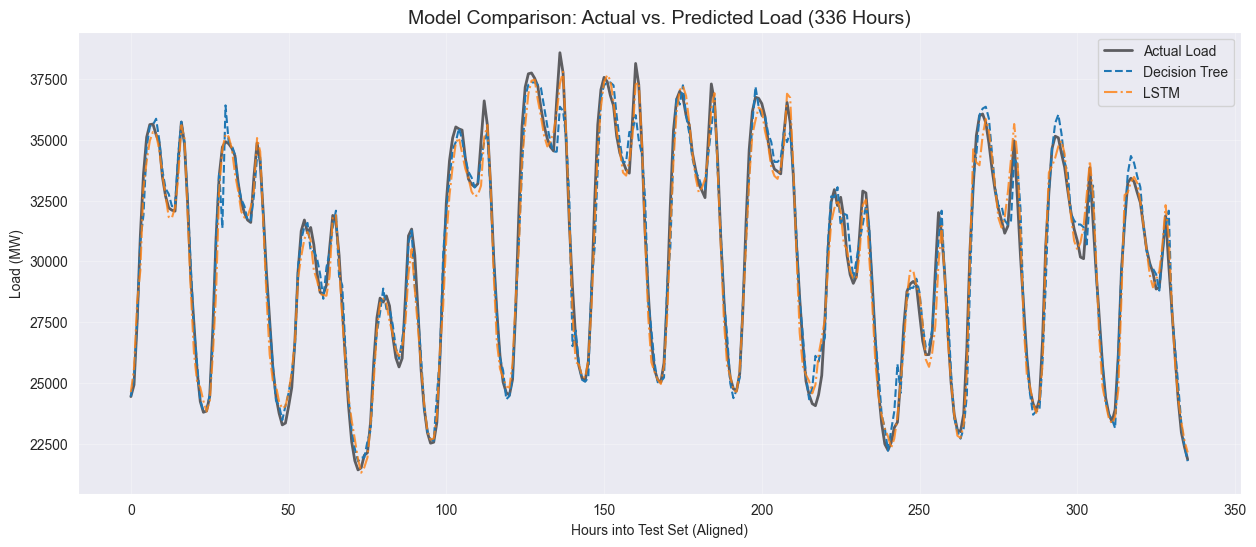

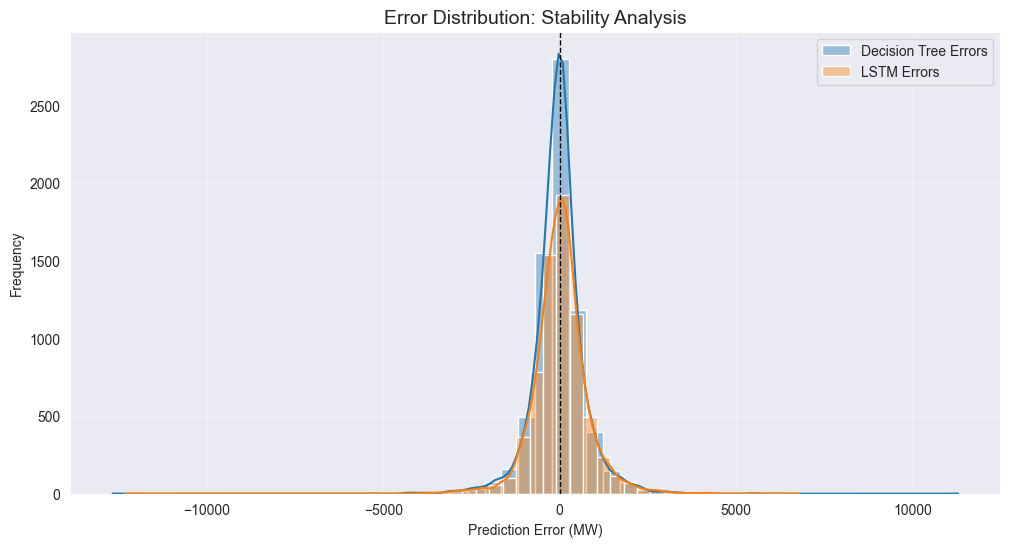

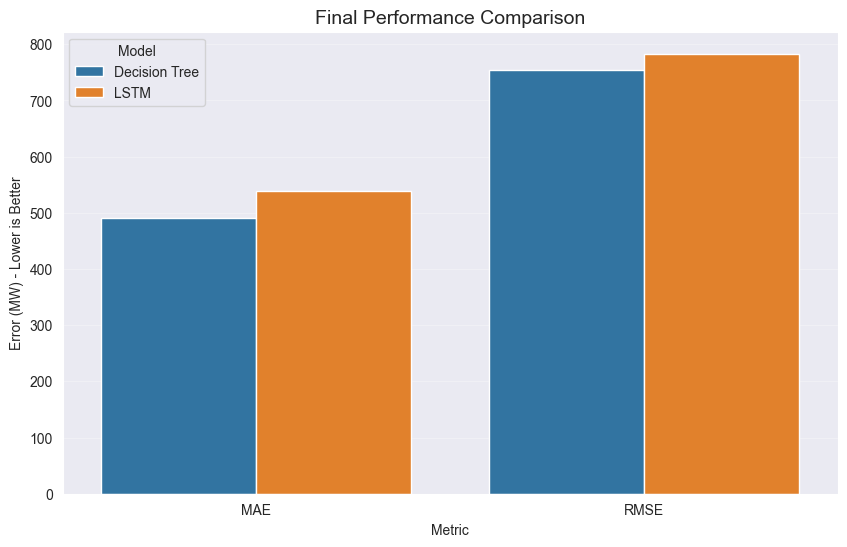

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Data Alignment ---
split_idx_dt = int(len(X) * 0.8)
split_idx_lstm = int((len(X) - 24) * 0.8)

start_idx_lstm_target = split_idx_lstm + 24
offset = start_idx_lstm_target - split_idx_dt

y_actual_aligned = y_test[offset:]
dt_preds_aligned = y_pred_final[offset:]
lstm_preds_aligned = y_pred_mw.flatten()

min_len = min(len(y_actual_aligned), len(lstm_preds_aligned))
y_actual_aligned = y_actual_aligned[:min_len]
dt_preds_aligned = dt_preds_aligned[:min_len]
lstm_preds_aligned = lstm_preds_aligned[:min_len]

# --- 2. Time-Series Overlay (2 Weeks) ---
window = 336
start_idx = 0

plt.figure(figsize=(15, 6))
plt.plot(y_actual_aligned[start_idx:start_idx+window], label='Actual Load', color='black', alpha=0.6, linewidth=2)
plt.plot(dt_preds_aligned[start_idx:start_idx+window], label='Decision Tree', color='#1f77b4', linestyle='--')
plt.plot(lstm_preds_aligned[start_idx:start_idx+window], label='LSTM', color='#ff7f0e', linestyle='-.', alpha=0.8)

plt.title(f'Model Comparison: Actual vs. Predicted Load ({window} Hours)', fontsize=14)
plt.ylabel('Load (MW)')
plt.xlabel('Hours into Test Set (Aligned)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 3. Error Distribution (Residuals) ---
dt_errors = y_actual_aligned - dt_preds_aligned
lstm_errors = y_actual_aligned - lstm_preds_aligned

plt.figure(figsize=(12, 6))
sns.histplot(dt_errors, color='#1f77b4', label='Decision Tree Errors', kde=True, alpha=0.4, bins=50)
sns.histplot(lstm_errors, color='#ff7f0e', label='LSTM Errors', kde=True, alpha=0.4, bins=50)

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Error Distribution: Stability Analysis', fontsize=14)
plt.xlabel('Prediction Error (MW)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 4. Performance Scorecard ---
metrics_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Decision Tree', 'LSTM', 'LSTM'],
    'Metric': ['MAE', 'RMSE', 'MAE', 'RMSE'],
    'Score (MW)': [mae_final, rmse_final, lstm_mae, lstm_rmse]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Metric', y='Score (MW)', hue='Model', palette=['#1f77b4', '#ff7f0e'])

plt.title('Final Performance Comparison', fontsize=14)
plt.ylabel('Error (MW) - Lower is Better')
plt.grid(True, axis='y', alpha=0.3)
plt.show()